In [15]:
import matplotlib.tri as tr
import numpy as np
import wildmeshing as wm
import polyfempy as pf
import cvxpy 
import copy
import igl
import meshplot as mp
import networkx as nx
import matplotlib.pyplot as plt
import svgwrite
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import random
import numpy as np
from numpy import linalg as LA
import math as m
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
from matplotlib.pyplot import figure
from scipy.spatial import Delaunay


colors= np.array(['#85C17E','#E2BC74','#425B8A','#B666D2','#85C17E'  ])

In [53]:
p1= np.array([[0,300],[200,300],[100,200],[100,100],[400,100],[400,0],[0,0]])
p2= np.array([[100,100],[100,200],[200,300],[400,300],[400,100]])
figure1= np.array([p1,p2])

#figure 2

f1= np.array([[0,0],[0,400],[200,400],[100,500],[300,500],[800,0]])
f2= np.array([[0,400],[200,400],[100,500],[300,500],[400,400],[800,400],[1000,200],[700,200],[800,100],[700,100],[800,0],[1000, 0], [1000,600], [0,600]])
f3= np.array([[500,300],[700,100],[800,100],[600,300],[500,300],[400,400], [800,400],[1000,200],[700,200],[600,300]])
f4= np.array([[500,300],[400,400], [800,400],[1000,200],[700,200],[600,300]])
figure2=np.array([f1,f2,f3,f4])
for i in range(len(figure2)):
    for j in range(len(figure2[i])):
        figure2[i][j][1]= 600-figure2[i][j][1]

#figure3
c1 = np.array([[0,0],[100,0],[100,200],[0,200]])
c2 = np.array([[100,200],[200,200],[200,500],[100,500]])
c3 = np.array([[200,100],[400,100],[400,200],[200,200]])
c4 = np.array([[300,200],[300,300],[400,300],[400,200]])
c5 = np.array([[400,100],[500,100],[500,300],[400,300]])
figure3=[c1,c2,c3,c4,c5]
print(np.max(figure2[0][:,0]))

800


In [54]:
def to_svg(figure):
    for i in range (len(figure)):
        fig= plt.figure(figsize=[5,5])
        plt.axis('off')
        ax = fig.gca()
        polygon = Polygon(figure[i], fill=False,edgecolor='black')
        ax.add_artist(polygon)
        ax.set(xlim=(0, np.max(figure[i][:,0])), ylim=(0, np.max(figure[i][:,1])))
        plt.gca().set_position([0, 0, 1, 1])
        plt.savefig("figure["+str(i)+"]"+".svg")

In [55]:
def displayPolygons(figure):
    patches = []
    xmax=0
    ymax=0
    fig = plt.figure(num=None, figsize=(10, 6))
    ax = fig.gca()
    for i in range(len(figure)):
        polygon = Polygon(figure[i], fill=True, facecolor=colors[i],edgecolor='black',label='figure'+str(i))
        ax.add_artist(polygon)
        if(xmax<np.max(figure[i][:,0])):
            xmax=np.max(figure[i][:,0])
        if(ymax<np.max(figure[i][:,1])):
            ymax=np.max(figure[i][:,1])
        
    ax.set(xlim=(0, xmax), ylim=(0, ymax))
    plt.show()
def display_polygon(polygon):
    patches = []
    xmax=500
    ymax=500
    fig = plt.figure(num=None, figsize=(10, 6))
    ax = fig.gca()

    polygon = Polygon(polygon, fill=True, facecolor=colors[0],edgecolor='black',label='figure')
    ax.add_artist(polygon)

        
    ax.set(xlim=(0, xmax), ylim=(0, ymax))
    plt.show()

In [56]:
def plot_tri_figure(figure):
    for i in range (figure.size):
        tri= Delaunay(figure[i])
        plt.triplot(figure[i][:,0], figure[i][:,1], tri.simplices.copy())
        plt.plot(figure[i][:,0], figure[i][:,1], 'o')
        plt.show()

In [75]:
def compute_normals(shape):
    vectors = np.array(copy.copy(shape), dtype='float32')
    for i in range(len(shape)):
        vectors[i]=np.array([shape[(i+1)%len(shape)][0]-shape[i][0], shape[(i+1)%len(shape)][1]-shape[i][1]])
    for i in range(len(vectors)):
        vectors[i][0], vectors[i][1] = -vectors[i][1], vectors[i][0] 
        vectors[i] /= LA.norm(vectors[i])        
    return vectors
def is_p1_blocking_p2_on_direction_d(p1,p2,d): #need to exclude normals that are not in touching areas
    blocking=False
    normals_1 = compute_normals(p1)
    for i  in range(len(normals_1)):
        for j in range(len(p2)):
            if isTouching(np.array([p1[i],p1[i+1%len(p1)]]),np.array([p2[j],p2[j+1%len(p2)]])) and d.T @ normals < 0:
                print(normals)
                print(d.T @ normals)
                blocking = True
                return blocking

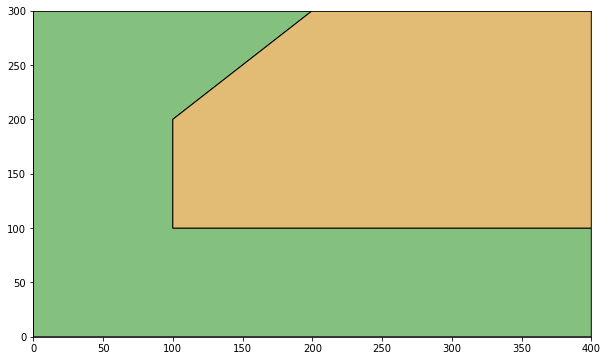

[[0. 1.]
 [1. 0.]]


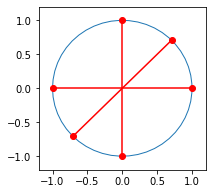

In [76]:
study(figure1)

In [78]:
is_p1_blocking_p2_on_direction_d(figure1[0],figure1[1], np.array([1,0]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

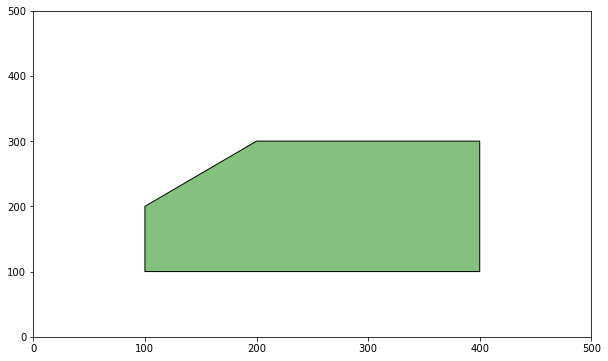

array([[-1.        ,  0.        ],
       [-0.70710677,  0.70710677],
       [-0.        ,  1.        ],
       [ 1.        ,  0.        ],
       [-0.        , -1.        ]], dtype=float32)

In [68]:
display_polygon(figure1[1])
compute_normals(figure1[1])

## here has problem

In [8]:
#construct all affines equations for all pairs of neighboors points for each shape belonging to the figure.
# y = a * x + b with a the slope, b the height at origin.
def constructAffineEquations(figure):
    equations=[[]]
    
    for i in range(len(figure)):   
        equationsLine=[]
        for j in range(len(figure[i])):
            if(figure[i][(j+1)%len(figure[i])][0]-figure[i][j][0] != 0):
                m=(figure[i][(j+1)%len(figure[i])][1]-figure[i][j][1])/(figure[i][(j+1)%len(figure[i])][0]-figure[i][j][0])
                oo=figure[i][j][1]-m*figure[i][j][0]
                equation=('y',m,'x',oo, figure[i][j], figure[i][(j+1)%len(figure[i])])
            else:
                equation=(figure[i][j][0],1,'x',0, figure[i][j], figure[i][(j+1)%len(figure[i])])
            equationsLine.append(equation) 
        equations.append(equationsLine)
    return equations

In [95]:
#return true if the 2 edges at points (a0,a1) and (b0,b1) are in contact, else false. could have been done in one function
def interval(a0,a1,b0,b1):
    if(a0>a1):
        a0,a1=a1,a0
    if(b0>b1):
        b0,b1=b1,b0
        
    interval=max(0, min(a1, b1) - max(a0, b0))
    return interval>0



def isTouching(e1, e2):
    if(np.array_equal(e1,e2)):
        return True
    
    elif(e1[0:4]==e2[0:4] )and (interval(e1[4][0],e1[5][0],e2[4][0],e2[5][0] ) or interval(e1[4][1],e1[5][1],e2[4][1],e2[5][1])):
        print(e1[0:4])
        return True
    return False


        

In [96]:
def constructNDBG(figure):
    equations= constructAffineEquations(figure)
    matrixNDBG= np.zeros((len(figure),len(figure)))
    for i in range(len(equations)):
        for j in range (len(equations)):

            for k in range (len(equations[i])):
                if(matrixNDBG[i-1][j-1]==1):
                    continue
                for l in range (len(equations[j])):
                    if(matrixNDBG[i-1][j-1]==1):
                            continue
                    if(k!=l and i!=j and isTouching(equations[j][l], equations[i][k])):

                        matrixNDBG[i-1][j-1]=1
                        #print(str(i) +' is touching '+ str(j))
                        
    return matrixNDBG    
        

In [97]:
#construct all affines equations for all pairs of neighboors points for each shape belonging to the figure.
def constructSlopes(figure):
    slopesSet=set()
    
    for i in range(len(figure)):   
        for j in range(len(figure[i])):
            if(figure[i][(j+1)%len(figure[i])][0]-figure[i][j][0] != 0):
                slope=m.atan((figure[i][(j+1)%len(figure[i])][1]-figure[i][j][1])/(figure[i][(j+1)%len(figure[i])][0]-figure[i][j][0]))
            else:
                slope=m.pi/2
            slopesSet.add(slope) 

    return slopesSet

In [98]:
def potentialDirections(figure):
    slopes = list(constructSlopes(figure))
    fig = plt.figure(num=None, figsize=(3, 3))
    t=np.linspace(-m.pi,m.pi)
    ax=fig.gca()
    ax.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))  
    ax.plot(np.cos(t), np.sin(t), linewidth=1)
    for i in range(len(slopes)):
        ax.plot((m.cos(slopes[i]),-m.cos(slopes[i])),(m.sin(slopes[i]),-m.sin(slopes[i])), 'ro-')
    ax.plot(t)
    

In [99]:
def study(figure):
    displayPolygons(figure)
    potentialDirections(figure)
    
    print(constructNDBG(figure))
    

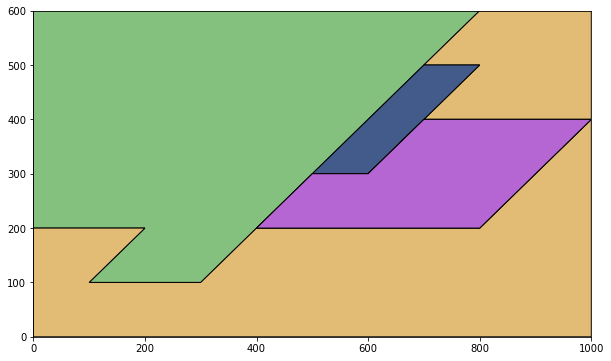

('y', 0.0, 'x', 200.0)
('y', 1.0, 'x', -200.0)
('y', 1.0, 'x', -200.0)
('y', 0.0, 'x', 200.0)
('y', 0.0, 'x', 200.0)
('y', 0.0, 'x', 200.0)
('y', 1.0, 'x', -200.0)
('y', -0.0, 'x', 500.0)
('y', 1.0, 'x', -300.0)
('y', 1.0, 'x', -200.0)
('y', 0.0, 'x', 200.0)
('y', 1.0, 'x', -200.0)
[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


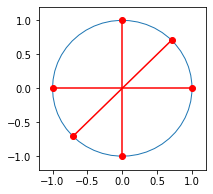

In [100]:
study(figure2)

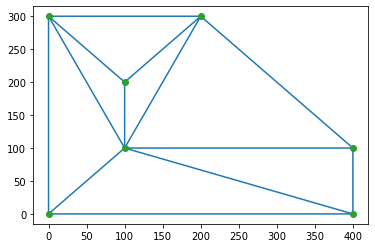

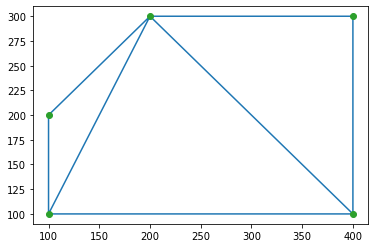

In [16]:
plot_tri_figure(figure1)